In [101]:
!pip install backtrader pandas numpy yfinance matplotlib scikit-learn xgboost


In [102]:
# importing all usefull libraries

import backtrader as bt
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from matplotlib.dates import DateFormatter
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler

In [103]:
# Download AMAZON data
amazon_data = yf.download("AMZN", start="2020-01-01", end="2025-01-01")
print(amazon_data.columns)

# Flatten the multi-index columns

amazon_data = amazon_data[['Open', 'High', 'Low', 'Close', 'Volume']]

# Add moving averages
amazon_data['MA_10'] = amazon_data['Close'].rolling(window=10).mean()
amazon_data['MA_50'] = amazon_data['Close'].rolling(window=50).mean()

# Add RSI
def compute_rsi(data, window=14):
    delta = data.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

amazon_data['RSI'] = compute_rsi(amazon_data['Close'])

# Add Bollinger Bands
amazon_data['BB_Middle'] = amazon_data['Close'].rolling(window=20).mean()
amazon_data['BB_Upper'] = amazon_data['BB_Middle'] + 2 * amazon_data['Close'].rolling(window=20).std()
amazon_data['BB_Lower'] = amazon_data['BB_Middle'] - 2 * amazon_data['Close'].rolling(window=20).std()

# Add moving averages
amazon_data['MA_10'] = amazon_data['Close'].rolling(window=10).mean()
amazon_data['MA_50'] = amazon_data['Close'].rolling(window=50).mean()


# Drop NaN values
amazon_data.dropna(inplace=True)

amazon_data.to_csv('amazon_data.csv', index=True)


# Drop NaN values
amazon_data.dropna(inplace=True)

# Load existing AMAZON data
amazon_data = pd.read_csv("amazon_data.csv", index_col=0, parse_dates=True)

# Compute Daily Returns
amazon_data['Daily_Return'] = amazon_data['Close'].pct_change()

# Add a 200-day moving average (long-term trend indicator)
amazon_data['MA_200'] = amazon_data['Close'].rolling(window=200).mean()

# Compute MACD (Moving Average Convergence Divergence)
short_ema = amazon_data['Close'].ewm(span=12, adjust=False).mean()  # Short-term EMA
long_ema = amazon_data['Close'].ewm(span=26, adjust=False).mean()   # Long-term EMA
amazon_data['MACD'] = short_ema - long_ema
amazon_data['Signal_Line'] = amazon_data['MACD'].ewm(span=9, adjust=False).mean()

# Compute ADX (Average Directional Index)
def compute_adx(data, window=14):
    high = data['High']
    low = data['Low']
    close = data['Close']
    
    plus_dm = high.diff()
    minus_dm = low.diff()
    
    plus_dm[plus_dm < 0] = 0
    minus_dm[minus_dm > 0] = 0
    
    tr1 = high - low
    tr2 = abs(high - close.shift(1))
    tr3 = abs(low - close.shift(1))
    tr = pd.concat([tr1, tr2, tr3], axis=1).max(axis=1)
    
    atr = tr.rolling(window).mean()
    plus_di = 100 * (plus_dm.rolling(window).mean() / atr)
    minus_di = 100 * (-minus_dm.rolling(window).mean() / atr)
    dx = (abs(plus_di - minus_di) / (plus_di + minus_di)) * 100
    adx = dx.rolling(window).mean()
    return adx

amazon_data['ADX'] = compute_adx(amazon_data)

# Compute ATR (Average True Range) for volatility measurement
high_low = amazon_data['High'] - amazon_data['Low']
high_close = abs(amazon_data['High'] - amazon_data['Close'].shift(1))
low_close = abs(amazon_data['Low'] - amazon_data['Close'].shift(1))
true_range = pd.concat([high_low, high_close, low_close], axis=1).max(axis=1)
amazon_data['ATR'] = true_range.rolling(window=14).mean()
# Simulated sentiment proxy: High/Low price ratio
amazon_data['Sentiment_Proxy'] = amazon_data['High'] / amazon_data['Low']

# Drop NaN values resulting from rolling calculations
amazon_data.dropna(inplace=True)

# Save the updated data
amazon_data.to_csv("amazon_data_updated.csv")

# Display the updated DataFrame
print(amazon_data.head())

[*********************100%%**********************]  1 of 1 completed

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')
                  Open        High         Low       Close     Volume  \
Date                                                                    
2020-12-24  159.695007  160.100006  158.449997  158.634506   29038000   
2020-12-28  159.699997  165.199997  158.634506  164.197998  113736000   
2020-12-29  165.496994  167.532501  164.061005  166.100006   97458000   
2020-12-30  167.050003  167.104996  164.123505  164.292496   64186000   
2020-12-31  163.750000  164.145996  162.059998  162.846497   59144000   

                 MA_10       MA_50        RSI   BB_Middle    BB_Upper  \
Date                                                                    
2020-12-24  159.439302  158.542550  51.593907  158.912850  162.807596   
2020-12-28  160.277002  158.487860  64.859379  159.134400  163.682957   
2020-12-29  161.102153  158.537151  66.348085  159.519301  165.011780   
2020-12-30  161.705803  158.615790  72.38992

In [104]:
# Feature Engineering: Adding Lag Features
for lag in range(1, 4):
    amazon_data[f'RSI_Lag_{lag}'] = amazon_data['RSI'].shift(lag)
    amazon_data[f'MACD_Lag_{lag}'] = amazon_data['MACD'].shift(lag)
    amazon_data[f'ADX_Lag_{lag}'] = amazon_data['ADX'].shift(lag)

amazon_data.dropna(inplace=True)

# Prepare data for modeling
features = amazon_data[['MA_10', 'MA_50', 'MA_200', 'RSI', 'MACD', 'Signal_Line', 'ADX', 'ATR', 'Sentiment_Proxy',
                        'RSI_Lag_1', 'MACD_Lag_1', 'ADX_Lag_1', 'RSI_Lag_2', 'MACD_Lag_2', 'ADX_Lag_2',
                        'RSI_Lag_3', 'MACD_Lag_3', 'ADX_Lag_3']]
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Apply PCA for dimensionality reduction
pca = PCA(n_components=7)
pca_features = pca.fit_transform(features_scaled)

# Prepare target variable (3-day forward prediction)
amazon_data['Target'] = np.where(amazon_data['Close'].shift(-3) > amazon_data['Close'], 1, 0)

# Ensure feature and target sizes match
pca_features = pca_features[:-3]
amazon_data = amazon_data.iloc[:-3]

X_train, X_test, y_train, y_test = train_test_split(pca_features, amazon_data['Target'], test_size=0.2, random_state=42)

# Hyperparameter tuning for Random Forest
rf_params = {'n_estimators': [100, 200], 'max_depth': [5, 10, None]}
rf_grid = GridSearchCV(RandomForestClassifier(random_state=42), rf_params, cv=3, scoring='accuracy')
rf_grid.fit(X_train, y_train)
rf_best = rf_grid.best_estimator_
rf_score = rf_best.score(X_test, y_test)
print(f"Optimized Random Forest Accuracy: {rf_score:.4f}")

# Hyperparameter tuning for XGBoost
xgb_params = {'learning_rate': [0.01, 0.1], 'max_depth': [3, 6], 'n_estimators': [100, 200]}
xgb_grid = GridSearchCV(estimator=xgb.XGBClassifier(), param_grid=xgb_params, cv=3, scoring='accuracy')

xgb_grid.fit(X_train, y_train)
xgb_best = xgb_grid.best_estimator_
xgb_score = xgb_best.score(X_test, y_test)
print(f"Optimized XGBoost Accuracy: {xgb_score:.4f}")

# Save the updated data
amazon_data.to_csv("amazon_data_updated.csv")

Optimized Random Forest Accuracy: 0.7015
Optimized XGBoost Accuracy: 0.6617


In [105]:
# Load preprocessed AMAZON data
amazon_data = pd.read_csv("amazon_data_updated.csv", index_col=0, parse_dates=True)

# Prepare data for modeling
features = amazon_data[['MA_10', 'MA_50', 'MA_200', 'RSI', 'MACD', 'Signal_Line', 'ADX', 'ATR', 'Sentiment_Proxy',
                        'RSI_Lag_1', 'MACD_Lag_1', 'ADX_Lag_1', 'RSI_Lag_2', 'MACD_Lag_2', 'ADX_Lag_2',
                        'RSI_Lag_3', 'MACD_Lag_3', 'ADX_Lag_3']]
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Prepare target variable (3-day forward prediction)
amazon_data['Target'] = np.where(amazon_data['Close'].shift(-3) > amazon_data['Close'], 1, 0)

# Ensure feature and target sizes match
features_scaled = features_scaled[:-3]
amazon_data = amazon_data.iloc[:-3]

X_train, X_test, y_train, y_test = train_test_split(features_scaled, amazon_data['Target'], test_size=0.2, random_state=42)

print("Starting Random Forest Optimization...")

# Random Forest Hyperparameter Optimization
rf_params = {
    'n_estimators': [100, 200],
    'max_depth': [5, 10, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}
rf_model = RandomizedSearchCV(RandomForestClassifier(random_state=42), rf_params, n_iter=5, cv=3, scoring='accuracy', random_state=42, verbose=1)
rf_model.fit(X_train, y_train)
rf_best = rf_model.best_estimator_
rf_score = rf_best.score(X_test, y_test)
print("Random Forest tuning complete.")
print(f"Optimized Random Forest Accuracy: {rf_score:.4f}")

print("\nStarting XGBoost Optimization...")

# XGBoost Hyperparameter Optimization
xgb_params = {
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 6],
    'n_estimators': [100, 200],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}
xgb_model = RandomizedSearchCV(xgb.XGBClassifier(eval_metric='logloss', use_label_encoder=False), xgb_params, n_iter=5, cv=3, scoring='accuracy', random_state=42, verbose=1)
xgb_model.fit(X_train, y_train)
xgb_best = xgb_model.best_estimator_
xgb_score = xgb_best.score(X_test, y_test)
print("XGBoost tuning complete.")
print(f"Optimized XGBoost Accuracy: {xgb_score:.4f}")

Starting Random Forest Optimization...
Fitting 3 folds for each of 5 candidates, totalling 15 fits
Random Forest tuning complete.
Optimized Random Forest Accuracy: 0.7164

Starting XGBoost Optimization...
Fitting 3 folds for each of 5 candidates, totalling 15 fits


c:\Users\adamr\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:26:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\adamr\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:26:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\adamr\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:26:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\adamr\anaconda3\Lib\site-packages\

XGBoost tuning complete.
Optimized XGBoost Accuracy: 0.7264


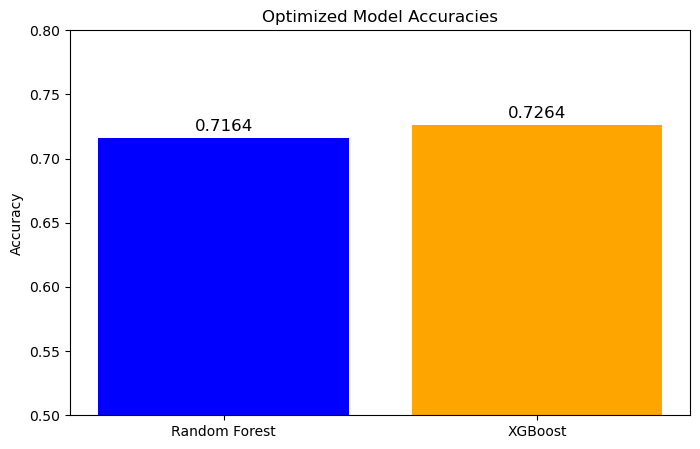

In [106]:
import matplotlib.pyplot as plt

# Model names and their accuracies
models = ["Random Forest", "XGBoost"]
accuracies = [0.7164, 0.7264]

# Plot the accuracies
plt.figure(figsize=(8, 5))
plt.bar(models, accuracies, color=['blue', 'orange'])
plt.ylim(0.5, 0.8)  # Set y-axis range to focus on accuracy differences
plt.ylabel("Accuracy")
plt.title("Optimized Model Accuracies")
plt.text(0, accuracies[0] + 0.005, f"{accuracies[0]:.4f}", ha='center', fontsize=12)
plt.text(1, accuracies[1] + 0.005, f"{accuracies[1]:.4f}", ha='center', fontsize=12)

# Show the plot
plt.show()


In [107]:
# Load data
amazon_data = pd.read_csv("amazon_data_updated.csv", index_col=0, parse_dates=True)

# Prepare Data for Modeling
features = amazon_data[['MA_10', 'MA_50', 'MA_200', 'RSI', 'MACD', 'Signal_Line', 'ADX', 'ATR', 'Sentiment_Proxy',
                        'RSI_Lag_1', 'MACD_Lag_1', 'ADX_Lag_1', 'RSI_Lag_2', 'MACD_Lag_2', 'ADX_Lag_2',
                        'RSI_Lag_3', 'MACD_Lag_3', 'ADX_Lag_3']]
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Prepare target variable (3-day forward prediction)
amazon_data['Target'] = np.where(amazon_data['Close'].shift(-3) > amazon_data['Close'], 1, 0)

# Ensure feature and target sizes match
features_scaled = features_scaled[:-3]
amazon_data = amazon_data.iloc[:-3]

X_train, X_test, y_train, y_test = train_test_split(features_scaled, amazon_data['Target'], test_size=0.2, random_state=42)

print("Starting Random Forest Optimization...")

# Random Forest Hyperparameter Optimization
rf_params = {
    'n_estimators': [100, 200],
    'max_depth': [5, 10, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}
rf_model = RandomizedSearchCV(RandomForestClassifier(random_state=42), rf_params, n_iter=5, cv=3, scoring='accuracy', random_state=42, verbose=1)
rf_model.fit(X_train, y_train)
rf_best = rf_model.best_estimator_
rf_score = rf_best.score(X_test, y_test)
print("Random Forest tuning complete.")
print(f"Optimized Random Forest Accuracy: {rf_score:.4f}")

print("\nStarting XGBoost Optimization...")

# XGBoost Hyperparameter Optimization
xgb_params = {
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 6],
    'n_estimators': [100, 200],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}
xgb_model = RandomizedSearchCV(xgb.XGBClassifier(eval_metric='logloss', use_label_encoder=False), xgb_params, n_iter=5, cv=3, scoring='accuracy', random_state=42, verbose=1)
xgb_model.fit(X_train, y_train)
xgb_best = xgb_model.best_estimator_
xgb_score = xgb_best.score(X_test, y_test)
print("XGBoost tuning complete.")
print(f"Optimized XGBoost Accuracy: {xgb_score:.4f}")

# Define a Backtrader Strategy using XGBoost Predictions
class XGBoostStrategy(bt.Strategy):
    params = (
        ('slippage', 0.002),  # 0.2% slippage
        ('commission', 0.004)  # 0.4% commission
    )
    
    def __init__(self):
        self.data_features = scaler.transform(amazon_data[['MA_10', 'MA_50', 'MA_200', 'RSI', 'MACD', 'Signal_Line', 'ADX', 'ATR', 'Sentiment_Proxy',
                                                           'RSI_Lag_1', 'MACD_Lag_1', 'ADX_Lag_1', 'RSI_Lag_2', 'MACD_Lag_2', 'ADX_Lag_2',
                                                           'RSI_Lag_3', 'MACD_Lag_3', 'ADX_Lag_3']])
        self.predictions = xgb_best.predict(self.data_features)
        self.current_index = 0
        self.portfolio_values = []  # Store portfolio values over time
    
    def next(self):
        if self.current_index >= len(self.predictions):
            return
        
        self.portfolio_values.append(self.broker.get_value())  # Record portfolio value at each step
        prediction = self.predictions[self.current_index]
        
        if not self.position:
            if prediction == 1:  # Buy condition from XGBoost Model
                self.buy()
        else:
            if prediction == 0:  # Sell condition from XGBoost Model
                self.sell()
        
        self.current_index += 1

# Create Backtrader Cerebro Engine
cerebro = bt.Cerebro()
cerebro.addstrategy(XGBoostStrategy)

# Convert DataFrame to Backtrader Datafeed
data = bt.feeds.PandasData(dataname=amazon_data)
cerebro.adddata(data)

# Set Broker Parameters
initial_cash = 100000  # Starting capital
cerebro.broker.set_cash(initial_cash)
cerebro.broker.setcommission(commission=0.004)  # 0.4% commission
cerebro.broker.set_slippage_perc(0.002)  # 0.2% slippage

# Run Backtest
print("Starting XGBoost Backtest...")
strategy = cerebro.run()[0]  # Retrieve strategy instance
print("Backtest Complete.")

# Extract Portfolio Value Over Time
portfolio_values = strategy.portfolio_values  # Use recorded values
final_cash = cerebro.broker.get_value()

# Print Starting and Ending Portfolio Values
print(f"Starting Portfolio Value: ${initial_cash:.2f}")
print(f"Ending Portfolio Value: ${final_cash:.2f}")


Starting Random Forest Optimization...
Fitting 3 folds for each of 5 candidates, totalling 15 fits
Random Forest tuning complete.
Optimized Random Forest Accuracy: 0.7164

Starting XGBoost Optimization...
Fitting 3 folds for each of 5 candidates, totalling 15 fits


c:\Users\adamr\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:26:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\adamr\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:26:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\adamr\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:26:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\adamr\anaconda3\Lib\site-packages\

XGBoost tuning complete.
Optimized XGBoost Accuracy: 0.7264
Starting XGBoost Backtest...
Backtest Complete.
Starting Portfolio Value: $100000.00
Ending Portfolio Value: $100363.10


In [108]:
import backtrader as bt
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter

# Load data
amazon_data = pd.read_csv("amazon_data_updated.csv", index_col=0, parse_dates=True)

# Define a Backtrader Strategy
class TradingStrategy(bt.Strategy):
    params = (
        ('sma_period', 50),
        ('slippage', 0.002),  # 0.2% slippage
        ('commission', 0.004)  # 0.4% commission
    )
    
    def __init__(self):
        self.sma = bt.indicators.SimpleMovingAverage(self.data.close, period=self.params.sma_period)
        self.portfolio_values = []  # Store portfolio values over time
    
    def next(self):
        self.portfolio_values.append(self.broker.get_value())  # Record portfolio value at each step
        if not self.position:
            if self.data.close[0] > self.sma[0]:  # Buy condition
                self.buy()
        elif self.data.close[0] < self.sma[0]:  # Sell condition
            self.sell()

# Create Backtrader Cerebro Engine
cerebro = bt.Cerebro()
cerebro.addstrategy(TradingStrategy)

# Convert DataFrame to Backtrader Datafeed
data = bt.feeds.PandasData(dataname=amazon_data)
cerebro.adddata(data)

# Set Broker Parameters
initial_cash = 100000  # Starting capital
cerebro.broker.set_cash(initial_cash)
cerebro.broker.setcommission(commission=0.004)  # 0.4% commission
cerebro.broker.set_slippage_perc(0.002)  # 0.2% slippage

# Run Backtest
print("Starting Backtest...")
strategy = cerebro.run()[0]  # Retrieve strategy instance
print("Backtest Complete.")

# Extract Portfolio Value Over Time
portfolio_values = strategy.portfolio_values  # Use recorded values
final_cash = cerebro.broker.get_value()

# Print Starting and Ending Portfolio Values
print(f"Starting Portfolio Value: ${initial_cash:.2f}")
print(f"Ending Portfolio Value: ${final_cash:.2f}")







Starting Backtest...
Backtest Complete.
Starting Portfolio Value: $100000.00
Ending Portfolio Value: $99995.73


In [109]:
import backtrader as bt
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler

# Load data
amazon_data = pd.read_csv("amazon_data_updated.csv", index_col=0, parse_dates=True)

# Prepare Data for Modeling
features = amazon_data[['MA_10', 'MA_50', 'MA_200', 'RSI', 'MACD', 'Signal_Line', 'ADX', 'ATR', 'Sentiment_Proxy',
                        'RSI_Lag_1', 'MACD_Lag_1', 'ADX_Lag_1', 'RSI_Lag_2', 'MACD_Lag_2', 'ADX_Lag_2',
                        'RSI_Lag_3', 'MACD_Lag_3', 'ADX_Lag_3']]
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Prepare target variable (3-day forward prediction)
amazon_data['Target'] = np.where(amazon_data['Close'].shift(-3) > amazon_data['Close'], 1, 0)

# Ensure feature and target sizes match
features_scaled = features_scaled[:-3]
amazon_data = amazon_data.iloc[:-3]

X_train, X_test, y_train, y_test = train_test_split(features_scaled, amazon_data['Target'], test_size=0.2, random_state=42)

print("Starting Random Forest Optimization...")

# Random Forest Hyperparameter Optimization
rf_params = {
    'n_estimators': [100, 200],
    'max_depth': [5, 10, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}
rf_model = RandomizedSearchCV(RandomForestClassifier(random_state=42), rf_params, n_iter=5, cv=3, scoring='accuracy', random_state=42, verbose=1)
rf_model.fit(X_train, y_train)
rf_best = rf_model.best_estimator_
rf_score = rf_best.score(X_test, y_test)
print("Random Forest tuning complete.")
print(f"Optimized Random Forest Accuracy: {rf_score:.4f}")

# Define a Backtrader Strategy using Random Forest Predictions
class RandomForestStrategy(bt.Strategy):
    params = (
        ('slippage', 0.002),  # 0.2% slippage
        ('commission', 0.004)  # 0.4% commission
    )
    
    def __init__(self):
        self.data_features = scaler.transform(amazon_data[['MA_10', 'MA_50', 'MA_200', 'RSI', 'MACD', 'Signal_Line', 'ADX', 'ATR', 'Sentiment_Proxy',
                                                           'RSI_Lag_1', 'MACD_Lag_1', 'ADX_Lag_1', 'RSI_Lag_2', 'MACD_Lag_2', 'ADX_Lag_2',
                                                           'RSI_Lag_3', 'MACD_Lag_3', 'ADX_Lag_3']])
        self.predictions = rf_best.predict(self.data_features)
        self.current_index = 0
        self.portfolio_values = []  # Store portfolio values over time
    
    def next(self):
        if self.current_index >= len(self.predictions):
            return
        
        self.portfolio_values.append(self.broker.get_value())  # Record portfolio value at each step
        prediction = self.predictions[self.current_index]
        
        if not self.position:
            if prediction == 1:  # Buy condition from Random Forest Model
                self.buy()
        else:
            if prediction == 0:  # Sell condition from Random Forest Model
                self.sell()
        
        self.current_index += 1

# Create Backtrader Cerebro Engine
cerebro = bt.Cerebro()
cerebro.addstrategy(RandomForestStrategy)

# Convert DataFrame to Backtrader Datafeed
data = bt.feeds.PandasData(dataname=amazon_data)
cerebro.adddata(data)

# Set Broker Parameters
initial_cash = 100000  # Starting capital
cerebro.broker.set_cash(initial_cash)
cerebro.broker.setcommission(commission=0.004)  # 0.4% commission
cerebro.broker.set_slippage_perc(0.002)  # 0.2% slippage

# Run Backtest
print("Starting Random Forest Backtest...")
strategy = cerebro.run()[0]  # Retrieve strategy instance
print("Backtest Complete.")

# Extract Portfolio Value Over Time
portfolio_values = strategy.portfolio_values  # Use recorded values
final_cash = cerebro.broker.get_value()

# Print Starting and Ending Portfolio Values
print(f"Starting Portfolio Value: ${initial_cash:.2f}")
print(f"Ending Portfolio Value: ${final_cash:.2f}")


Starting Random Forest Optimization...
Fitting 3 folds for each of 5 candidates, totalling 15 fits
Random Forest tuning complete.
Optimized Random Forest Accuracy: 0.7164
Starting Random Forest Backtest...
Backtest Complete.
Starting Portfolio Value: $100000.00
Ending Portfolio Value: $100388.16


In [110]:

# Load data
amazon_data = pd.read_csv("amazon_data_updated.csv", index_col=0, parse_dates=True)

# Prepare Data for Modeling
features = amazon_data[['MA_10', 'MA_50', 'MA_200', 'RSI', 'MACD', 'Signal_Line', 'ADX', 'ATR', 'Sentiment_Proxy',
                        'RSI_Lag_1', 'MACD_Lag_1', 'ADX_Lag_1', 'RSI_Lag_2', 'MACD_Lag_2', 'ADX_Lag_2',
                        'RSI_Lag_3', 'MACD_Lag_3', 'ADX_Lag_3']]
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Prepare target variable (3-day forward prediction)
amazon_data['Target'] = np.where(amazon_data['Close'].shift(-3) > amazon_data['Close'], 1, 0)

# Ensure feature and target sizes match
features_scaled = features_scaled[:-3]
amazon_data = amazon_data.iloc[:-3]

X_train, X_test, y_train, y_test = train_test_split(features_scaled, amazon_data['Target'], test_size=0.2, random_state=42)

print("Starting XGBoost Optimization...")

# XGBoost Hyperparameter Optimization
xgb_params = {
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 6],
    'n_estimators': [100, 200],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}
xgb_model = RandomizedSearchCV(xgb.XGBClassifier(eval_metric='logloss', use_label_encoder=False), xgb_params, n_iter=5, cv=3, scoring='accuracy', random_state=42, verbose=1)
xgb_model.fit(X_train, y_train)
xgb_best = xgb_model.best_estimator_
xgb_score = xgb_best.score(X_test, y_test)
print("XGBoost tuning complete.")
print(f"Optimized XGBoost Accuracy: {xgb_score:.4f}")

# Define a Backtrader Strategy with Improved Risk Management
class ImprovedRiskManagedStrategy(bt.Strategy):
    params = (
        ('slippage', 0.002),  # 0.2% slippage
        ('commission', 0.004),  # 0.4% commission
        ('stop_loss_factor', 1.2),  # ATR-based stop-loss
        ('take_profit_factor', 2.5),  # ATR-based take-profit
        ('max_positions', 10),  # Maximum 10 positions at once
        ('capital_per_trade', 0.05),  # 5% of capital per trade
        ('min_confidence', 0.7)  # Minimum confidence for trade execution
    )
    
    def __init__(self):
        self.data_features = scaler.transform(amazon_data[['MA_10', 'MA_50', 'MA_200', 'RSI', 'MACD', 'Signal_Line', 'ADX', 'ATR', 'Sentiment_Proxy',
                                                           'RSI_Lag_1', 'MACD_Lag_1', 'ADX_Lag_1', 'RSI_Lag_2', 'MACD_Lag_2', 'ADX_Lag_2',
                                                           'RSI_Lag_3', 'MACD_Lag_3', 'ADX_Lag_3']])
        self.probabilities = xgb_best.predict_proba(self.data_features)[:, 1]  # Get probability of price increase
        self.current_index = 0
        self.portfolio_values = []  # Store portfolio values over time
        self.atr = bt.indicators.AverageTrueRange(period=14)  # Define ATR indicator
    
    def next(self):
        if self.current_index >= len(self.probabilities):
            return
        
        self.portfolio_values.append(self.broker.get_value())  # Record portfolio value at each step
        confidence = self.probabilities[self.current_index]
        cash = self.broker.get_cash()
        size = min((cash * self.params.capital_per_trade) / self.data.close[0], cash / self.data.close[0])  # Ensure no over-leveraging
        size = max(size, 1)  # Prevent extremely small or large positions
        atr_value = self.atr[0]  # Fetch current ATR value
        
        if not self.position and len(self.broker.positions) < self.params.max_positions:
            if confidence > self.params.min_confidence:  # Trade only when confidence is high
                self.buy(size=size)
                self.sell(size=size, exectype=bt.Order.Stop, price=self.data.close[0] - self.params.stop_loss_factor * atr_value)  # ATR-based Stop-loss
                self.sell(size=size, exectype=bt.Order.Limit, price=self.data.close[0] + self.params.take_profit_factor * atr_value)  # ATR-based Take-profit
        
        elif self.position:
            if confidence < (1 - self.params.min_confidence):  # Sell if confidence is too low
                self.close()  # Close all positions properly
        
        self.current_index += 1

# Create Backtrader Cerebro Engine
cerebro = bt.Cerebro()
cerebro.addstrategy(ImprovedRiskManagedStrategy)

# Convert DataFrame to Backtrader Datafeed
data = bt.feeds.PandasData(dataname=amazon_data)
cerebro.adddata(data)

# Set Broker Parameters
initial_cash = 100000  # Starting capital
cerebro.broker.set_cash(initial_cash)
cerebro.broker.setcommission(commission=0.004)  # 0.4% commission
cerebro.broker.set_slippage_perc(0.002)  # 0.2% slippage

# Run Backtest
print("Starting Improved Risk-Managed Backtest...")
strategy = cerebro.run()[0]  # Retrieve strategy instance
print("Backtest Complete.")

# Extract Portfolio Value Over Time
portfolio_values = strategy.portfolio_values  # Use recorded values
final_cash = cerebro.broker.get_value()

# Print Starting and Ending Portfolio Values
print(f"Starting Portfolio Value: ${initial_cash:.2f}")
print(f"Ending Portfolio Value: ${final_cash:.2f}")


Starting XGBoost Optimization...
Fitting 3 folds for each of 5 candidates, totalling 15 fits


c:\Users\adamr\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:26:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\adamr\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:26:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\adamr\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:26:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\adamr\anaconda3\Lib\site-packages\

XGBoost tuning complete.
Optimized XGBoost Accuracy: 0.7264
Starting Improved Risk-Managed Backtest...
Backtest Complete.
Starting Portfolio Value: $100000.00
Ending Portfolio Value: $84660.96


In [111]:
# Load data
amazon_data = pd.read_csv("amazon_data_updated.csv", index_col=0, parse_dates=True)

# Prepare Data for Modeling
features = amazon_data[['MA_10', 'MA_50', 'MA_200', 'RSI', 'MACD', 'Signal_Line', 'ADX', 'ATR', 'Sentiment_Proxy',
                        'RSI_Lag_1', 'MACD_Lag_1', 'ADX_Lag_1', 'RSI_Lag_2', 'MACD_Lag_2', 'ADX_Lag_2',
                        'RSI_Lag_3', 'MACD_Lag_3', 'ADX_Lag_3']]
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Prepare target variable (3-day forward prediction)
amazon_data['Target'] = np.where(amazon_data['Close'].shift(-3) > amazon_data['Close'], 1, 0)

# Ensure feature and target sizes match
features_scaled = features_scaled[:-3]
amazon_data = amazon_data.iloc[:-3]

X_train, X_test, y_train, y_test = train_test_split(features_scaled, amazon_data['Target'], test_size=0.2, random_state=42)

print("Starting Random Forest Optimization...")

# Random Forest Hyperparameter Optimization
rf_params = {
    'n_estimators': [100, 200],
    'max_depth': [5, 10, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}
rf_model = RandomizedSearchCV(RandomForestClassifier(random_state=42), rf_params, n_iter=5, cv=3, scoring='accuracy', random_state=42, verbose=1)
rf_model.fit(X_train, y_train)
rf_best = rf_model.best_estimator_
rf_score = rf_best.score(X_test, y_test)
print(f"Optimized Random Forest Accuracy: {rf_score:.4f}")

# Define a Backtrader Strategy with Improved Risk Management
class RandomForestStrategy(bt.Strategy):
    params = (
        ('slippage', 0.002),  # 0.2% slippage
        ('commission', 0.004),  # 0.4% commission
        ('stop_loss_factor', 1.2),  # ATR-based stop-loss
        ('take_profit_factor', 2.5),  # ATR-based take-profit
        ('max_positions', 10),  # Maximum 10 positions at once
        ('capital_per_trade', 0.05),  # 5% of capital per trade
        ('min_confidence', 0.7)  # Minimum confidence for trade execution
    )
    
    def __init__(self):
        self.data_features = scaler.transform(amazon_data[['MA_10', 'MA_50', 'MA_200', 'RSI', 'MACD', 'Signal_Line', 'ADX', 'ATR', 'Sentiment_Proxy',
                                                           'RSI_Lag_1', 'MACD_Lag_1', 'ADX_Lag_1', 'RSI_Lag_2', 'MACD_Lag_2', 'ADX_Lag_2',
                                                           'RSI_Lag_3', 'MACD_Lag_3', 'ADX_Lag_3']])
        self.rf_probabilities = rf_best.predict_proba(self.data_features)[:, 1]  # RF Probabilities
        self.current_index = 0
        self.portfolio_values = []  # Store portfolio values over time
        self.atr = bt.indicators.AverageTrueRange(period=14)  # Define ATR indicator
    
    def next(self):
        if self.current_index >= len(self.rf_probabilities):
            return
        
        self.portfolio_values.append(self.broker.get_value())  # Record portfolio value at each step
        rf_confidence = self.rf_probabilities[self.current_index]
        cash = self.broker.get_cash()
        size = min((cash * self.params.capital_per_trade) / self.data.close[0], cash / self.data.close[0])  # Ensure no over-leveraging
        size = max(size, 1)  # Prevent extremely small or large positions
        atr_value = self.atr[0]  # Fetch current ATR value
        
        if not self.position and len(self.broker.positions) < self.params.max_positions:
            if rf_confidence > self.params.min_confidence:  # Trade only when confidence is high
                self.buy(size=size)
                self.sell(size=size, exectype=bt.Order.Stop, price=self.data.close[0] - self.params.stop_loss_factor * atr_value)  # ATR-based Stop-loss
                self.sell(size=size, exectype=bt.Order.Limit, price=self.data.close[0] + self.params.take_profit_factor * atr_value)  # ATR-based Take-profit
        
        elif self.position:
            if rf_confidence < (1 - self.params.min_confidence):  # Sell if confidence is too low
                self.close()  # Close all positions properly
        
        self.current_index += 1

# Create Backtrader Cerebro Engine
cerebro = bt.Cerebro()
cerebro.addstrategy(RandomForestStrategy)

# Convert DataFrame to Backtrader Datafeed
data = bt.feeds.PandasData(dataname=amazon_data)
cerebro.adddata(data)

# Set Broker Parameters
initial_cash = 100000  # Starting capital
cerebro.broker.set_cash(initial_cash)
cerebro.broker.setcommission(commission=0.004)  # 0.4% commission
cerebro.broker.set_slippage_perc(0.002)  # 0.2% slippage

# Run Backtest
print("Starting Random Forest Backtest...")
strategy = cerebro.run()[0]  # Retrieve strategy instance
print("Backtest Complete.")

# Extract Portfolio Value Over Time
portfolio_values = strategy.portfolio_values  # Use recorded values
final_cash = cerebro.broker.get_value()

# Print Starting and Ending Portfolio Values
print(f"Starting Portfolio Value: ${initial_cash:.2f}")
print(f"Ending Portfolio Value: ${final_cash:.2f}")

Starting Random Forest Optimization...
Fitting 3 folds for each of 5 candidates, totalling 15 fits
Optimized Random Forest Accuracy: 0.7164
Starting Random Forest Backtest...
Backtest Complete.
Starting Portfolio Value: $100000.00
Ending Portfolio Value: $86546.56


In [ ]:
import backtrader as bt
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import os

# Load the test datasets
file_names = [
    ('btc_v_w.csv', ','),
    ('ge_us_m.csv', ','),
    ('usdjpy_w.csv', ','),
    ('wig20_w.csv', ','),
    ('zw=f_copper.csv', ';')  # Copper uses semicolon separator
]

def load_data(file_name, separator):
    df = pd.read_csv(file_name, index_col=0, parse_dates=True, delimiter=separator)
    
    # Rename columns to match Backtrader's expected format
    column_mapping = {
        'Max': 'High',
        'Min': 'Low',
        'Close': 'Close',
        'Open': 'Open'
    }
    
    df = df.rename(columns=column_mapping)
    
    # Only select the columns we need for Backtrader
    required_columns = ['Open', 'High', 'Low', 'Close']
    df = df[required_columns].dropna()
    
    # Ensure all price columns are numeric
    for col in required_columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    
    return df.dropna()

class RandomForestStrategy(bt.Strategy):
    params = (
        ('slippage', 0.002),
        ('commission', 0.004),
        ('stop_loss_factor', 1.2),
        ('take_profit_factor', 2.5),
        ('max_positions', 10),
        ('capital_per_trade', 0.05),
        ('min_confidence', 0.7)
    )
    
    def __init__(self):
        self.atr = bt.indicators.AverageTrueRange(period=14)
        self.order = None
        self.stop_order = None
        self.profit_order = None
        self.portfolio_values = []
    
    def next(self):
        # Track portfolio value for time series analysis
        self.portfolio_values.append(self.broker.get_value())

        if self.order or self.stop_order or self.profit_order:
            return
        
        cash = self.broker.get_cash()
        value = self.broker.get_value()
        
        size = (value * self.params.capital_per_trade) / self.data.close[0]
        size = max(size, 1)
        
        atr_value = self.atr[0]
        
        if not self.position and len(self.broker.positions) < self.params.max_positions:
            self.order = self.buy(size=size)
            
            stop_price = self.data.close[0] - self.params.stop_loss_factor * atr_value
            profit_price = self.data.close[0] + self.params.take_profit_factor * atr_value
            
            self.stop_order = self.sell(size=size, exectype=bt.Order.Stop, price=stop_price, parent=self.order)
            self.profit_order = self.sell(size=size, exectype=bt.Order.Limit, price=profit_price, parent=self.order)
    
    def stop(self):
        if self.position:
            self.close()

# Run backtest for each dataset
results = []

for file_name, separator in file_names:
    print(f"\nStarting Backtest for {file_name}...")
    
    df = load_data(file_name, separator)
    if df is None:
        continue
    
    data = bt.feeds.PandasData(dataname=df)
    
    cerebro = bt.Cerebro()
    cerebro.addstrategy(RandomForestStrategy)
    cerebro.adddata(data)
    
    initial_cash = 100000
    cerebro.broker.set_cash(initial_cash)
    cerebro.broker.setcommission(commission=0.004)
    cerebro.broker.set_slippage_perc(0.002)
    
    strategies = cerebro.run()
    strategy = strategies[0]
    
    final_value = cerebro.broker.get_value()
    returns = (final_value - initial_cash) / initial_cash * 100
    
    # Calculate max drawdown and Sharpe ratio
    portfolio_values = np.array(strategy.portfolio_values)
    max_dd = np.max(np.maximum.accumulate(portfolio_values) - portfolio_values) / np.max(np.maximum.accumulate(portfolio_values))
    sharpe_ratio = np.mean(np.diff(portfolio_values) / portfolio_values[:-1]) / np.std(np.diff(portfolio_values) / portfolio_values[:-1]) * np.sqrt(252)
    
    results.append({
        'Timeseries': file_name,
        'Return (%)': returns,
        'Max Drawdown': max_dd,
        'Sharpe Ratio': sharpe_ratio
    })

# Convert results into a DataFrame and display it
results_df = pd.DataFrame(results)
print(results_df)




Starting Backtest for btc_v_w.csv...
4417360187.351304

Starting Backtest for ge_us_m.csv...
355973.2779070342

Starting Backtest for usdjpy_w.csv...
98023.38598551182

Starting Backtest for wig20_w.csv...
99158.36955717081

Starting Backtest for zw=f_copper.csv...


C:\Users\adamr\AppData\Local\Temp\ipykernel_27100\243012861.py:17: UserWarning: Parsing dates in %d.%m.%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df = pd.read_csv(file_name, index_col=0, parse_dates=True, delimiter=separator)


103896.46688780488
        Timeseries    Return (%)  Max Drawdown  Sharpe Ratio
0      btc_v_w.csv  4.417260e+06      0.462573      2.802104
1      ge_us_m.csv  2.559733e+02      0.691110      1.069648
2     usdjpy_w.csv -1.976614e+00      0.024506     -0.537042
3      wig20_w.csv -8.416304e-01      0.043930     -0.098725
4  zw=f_copper.csv  3.896467e+00      0.130593      0.172271
